[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds4v/absa-vlsp-2018/blob/main/experiments/Hotel-v1.ipynb)

In [1]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 require

In [2]:
!git clone https://github.com/ds4v/absa-vlsp-2018.git
%cd ./absa-vlsp-2018/experiments
!mkdir predictions
!ls

Cloning into 'absa-vlsp-2018'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 224 (delta 61), reused 105 (delta 36), pack-reused 89
Receiving objects: 100% (224/224), 31.67 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/absa-vlsp-2018/experiments
Hotel-v1.ipynb	Hotel-v2.ipynb	predictions  Restaurant-v1.ipynb  Restaurant-v2.ipynb


In [2]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

'2.15.0'

In [3]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Constants Setup and Load the Data

In [4]:
TRAIN_PATH = r'../datasets/vlsp2018_restaurant/1-VLSP2018-SA-Restaurant-train.csv'
VAL_PATH = r'../datasets/vlsp2018_restaurant/2-VLSP2018-SA-Restaurant-dev.csv'
TEST_PATH = r'../datasets/vlsp2018_restaurant/3-VLSP2018-SA-Restaurant-test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Restaurant-v1' # Multitask model on Restaurant domain
MAX_LENGTH = 256
BATCH_SIZE = 21
EPOCHS = 20

In [5]:
from processors.vlsp2018_processor import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['Review', 'AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL'],
        num_rows: 500
    })
})

# Preprocess and Tokenize the Data

In [7]:
from processors.vietnamese_processor import VietnameseTextPreprocessor

# You should be carefull when using single word replacement for acronyms, because it can cause misinterpretation.
# For example, 'giá': ['price', 'gia'] can replace the word 'gia' in 'gia đình', making it become 'giá đình'.
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

VnCoreNLP word segmenter is loaded successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

bmd1905/vietnamese-correction-v2 is loaded successfully.


In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode('Tôi là sinh_viên trường đại_học Công_nghệ thông_tin .')
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encode: [0, 218, 8, 649, 212, 956, 2413, 195, 5, 2] 
Decode: <s> Tôi là sinh_viên trường đại_học Công_nghệ thông_tin. </s>


['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
# preprocessed_datasets.save_to_disk('../datasets/preprocessed_restaurant')
# display(preprocessed_datasets)
# pd.DataFrame({
#     'raw_datasets': raw_datasets['train']['Review'][:10],
#     'encoded_input_ids': preprocessed_datasets['train']['input_ids'][:10],
#     'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(10)]
# })

[INFO] Preprocessing and tokenizing text data...


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map:   0%|          | 0/1290 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2961 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1290 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'S

,raw_datasets,encoded_input_ids,decoded_input_ids
0,"_ Ảnh chụp từ hôm qua, đi chơi với gia đình và...","[0, 284, 690, 39, 2402, 57, 379, 15, 161, 6, 9...",<s> ảnh chụp từ hôm_qua đi chơi với gia_đình v...
1,"_Hương vị thơm ngon, ăn cay cay rất thích, nêm...","[0, 4088, 2023, 21474, 4205, 4205, 59, 543, 61...",<s> hương_vị thơm ngon_ăn cay cay rất thích nê...
2,- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt ...,"[0, 99, 509, 2418, 4600, 107, 802, 203, 4397, ...",<s> 1 bàn tiệc hoành_tráng 3 đứa ăn no muốn tắ...
3,- Các bạn nhìn cái chảo này có to không 🙄🙄🙄- T...,"[0, 9, 88, 364, 224, 5596, 23, 10, 889, 17, 34...",<s> các bạn nhìn cái chảo này có to không trên...
4,"- Cháo: có nhiều hương cho các bạn chọn, nhưng...","[0, 4951, 10, 36, 2263, 13, 9, 88, 437, 51, 68...",<s> cháo có nhiều hương cho các bạn chọn nhưng...
5,"- Đồ nướng thì chỗ này không ít bạn ""chẻ"" biết...","[0, 779, 3030, 54, 683, 23, 17, 343, 88, 4241,...",<s> đồ nướng thì chỗ này không ít bạn chê biết...
6,- Đói không ngủ được nên up hình đồ ăn cho mấy...,"[0, 3442, 17, 845, 11, 77, 7249, 819, 4036, 13...",<s> đói không ngủ được nên up hình đồ_ăn cho m...
7,"- Khẩu vị vừa ăn hợp vệ sinh , không gian quán...","[0, 13284, 164, 203, 2288, 1540, 1152, 946, 72...",<s> khẩu_vị vừa ăn hợp vệ_sinh không_gian quán...
8,- Kimchi Kimchi 😹😹- Nói cho cùng thì đồ ăn càn...,"[0, 39010, 811, 39010, 811, 96, 13, 81, 54, 40...",<s> kimchi kimchi nói cho cùng thì đồ_ăn càng ...
9,- Lẩu hàu thì chưa thấy đâu có. Mới ăn lần đầu...,"[0, 8510, 15389, 54, 102, 108, 602, 10, 60, 20...",<s> lẩu hàu thì chưa thấy đâu có mới ăn lần đầ...


# Extra Step for ACSA-v1 Solution

In [8]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_restaurant')
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2961
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1290
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [9]:
print('Aspect#Category,Polarity in One-hot form of the first review:')
example_onehot = preprocessed_datasets['train'][0]['FlattenOneHotLabels']
np.array(example_onehot).reshape(-1, 4)

Aspect#Category,Polarity in One-hot form of the first review:


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

# Prepare for TensorFlow Training

In [10]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(ASPECT_CATEGORY_NAMES)

['AMBIENCE#GENERAL', 'DRINKS#PRICES', 'DRINKS#QUALITY', 'DRINKS#STYLE&OPTIONS', 'FOOD#PRICES', 'FOOD#QUALITY', 'FOOD#STYLE&OPTIONS', 'LOCATION#GENERAL', 'RESTAURANT#GENERAL', 'RESTAURANT#MISCELLANEOUS', 'RESTAURANT#PRICES', 'SERVICE#GENERAL']


In [20]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True, # You can obtain HIGHER metrics on the test set with longer training time if you set this to False
    # Because after some experiments, I found that even with higher val_loss, it still results in better metric reports on the test set. 
    # This maybe because the training set and the test set have more similarities than the validation data.
    # But I think this is not fair, as we already have prior knowledge about the test set and we modified our training based on the performance on this set. 
    # In real-world, we should only modify our training based on the performance on the validation data
    verbose = 1
)

# Fine-tuning with TensorFlow

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


141/141 [==============================] - 122s 456ms/step - loss: 0.2265 - val_loss: 0.1706
Epoch 2/20
141/141 [==============================] - 56s 357ms/step - loss: 0.1543 - val_loss: 0.1433
Epoch 3/20
141/141 [==============================] - 55s 350ms/step - loss: 0.1139 - val_loss: 0.1334
Epoch 4/20
141/141 [==============================] - 54s 346ms/step - loss: 0.0864 - val_loss: 0.1377
Epoch 5/20
141/141 [==============================] - 54s 347ms/step - loss: 0.0606 - val_loss: 0.1703
Epoch 6/20
141/141 [==============================] - 54s 348ms/step - loss: 0.0330 - val_loss: 0.1804
Epoch 6: early stopping


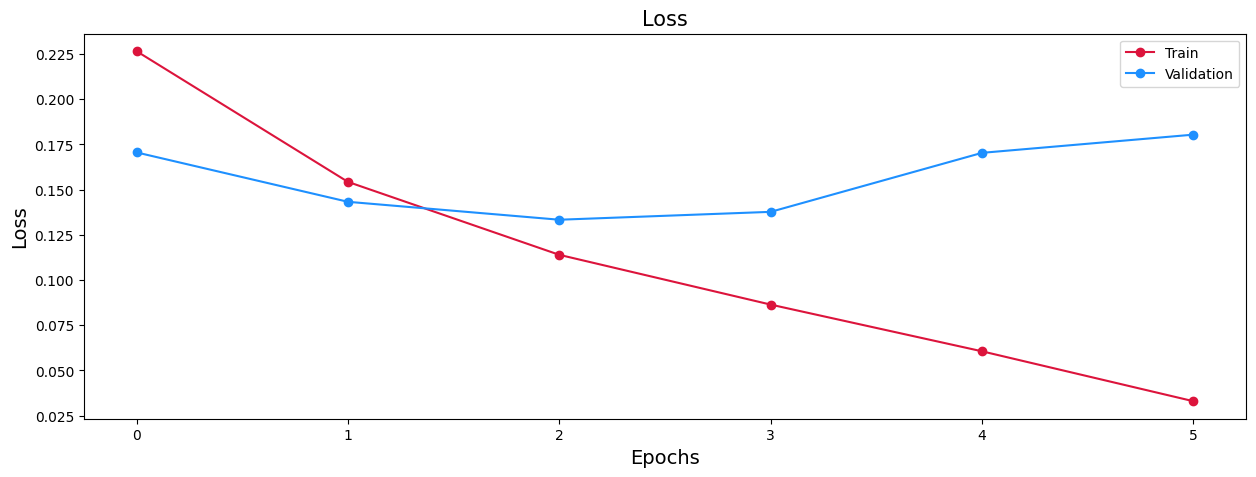

CPU times: user 4min 15s, sys: 34.3 s, total: 4min 49s
Wall time: 6min 39s


In [22]:
%%time
from acsa_model import VLSP2018MultiTask
from helper import plot_training_history
model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

model.save_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}', save_format='tf')
plot_training_history(history)

In [27]:
from google.colab import drive # Move weights to Drive for faster downloading
drive.mount('/content/GoogleDrive', force_remount=True)
!zip -r ./weights/{MODEL_NAME}.zip ./weights/{MODEL_NAME}
!mv ./weights/{MODEL_NAME}.zip /content/GoogleDrive/My\ Drive

Mounted at /content/GoogleDrive
  adding: weights/Restaurant-v1/ (stored 0%)
  adding: weights/Restaurant-v1/checkpoint (deflated 39%)
  adding: weights/Restaurant-v1/Restaurant-v1.index (deflated 80%)
  adding: weights/Restaurant-v1/Restaurant-v1.data-00000-of-00001 (deflated 32%)


# Predict on the Test Data

In [28]:
from acsa_model import VLSP2018MultiTask
reloaded_model = VLSP2018MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)
reloaded_model.load_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}') # Reload the Model
reloaded_model.evaluate(val_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


62/62 [==============================] - 29s 104ms/step - loss: 0.1334


0.13335208594799042

In [29]:
y_pred = reloaded_model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
reloaded_model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)
print('Example:', raw_datasets['test'][0]['Review'])
reloaded_model.print_acsa_pred(y_pred[0])

24/24 [==============================] - 8s 104ms/step - loss: 0.2770
Example: Đây là 1 trong những quán mà mình thích vì vị trà đậm và thơm cũng như mùi vị đặc trưng hơn hẳn những quán khác nè  Trà sữa trân châu sợi - 46k Trà sữa pha khá ngon, vị trà chát và mùi hương khá rõ, không quá ngọt, rất đúng với gu mình  Trà đào - 45k Vị trà đào ở đây cũng đặc biệt hơn hẳn những quán khác, không phải chua ngọt như thưởng thấy mà có mùi trà rất ngon  Cà phê đá xay - 65k Món đá xay ở đây uống cũng ngon không kém trà nè, mùi vị thơm hương cà phê, vị đắng kết hợp hoàn hảo với độ béo ngọt của whipping cream, không quá đắng, cũng không quá ngọt hay lạt lẽo mà dịu nhẹ, thơm và dễ uống lắm  Trà vải thiết quan âm - 45k Trà vải có mùi vị rất thơm ngon mùi vải mà vẫn nghe rõ vị trà, có chút vị chát nhẹ mùi trà thơm rất thích, không phải chỉ toàn vị syrup vải ngọt gắt như nhiều chỗ khác. Do trà ở đây pha khá đậm nên bạn nào uống mà đang đói sẽ dễ say nha, hoặc ban đêm có thể khó ngủ à, cảnh báo trước  Tr

In [33]:
from tensorflow.data import Dataset # On a random review by user
random_input = VLSP2018Loader.preprocess_and_tokenize(
    input('Enter your review: '), vn_preprocessor, tokenizer,
    batch_size=1, max_length=MAX_LENGTH
)
tf_inputs = Dataset.from_tensor_slices({x: [[random_input[x][0]]] for x in tokenizer.model_input_names})
random_pred = reloaded_model.acsa_predict(tf_inputs)
reloaded_model.print_acsa_pred(random_pred[0])

Enter your review: Giá cũng ok mà nhân viên hơi thiếu chuyên nghiệp
[INFO] Preprocessing and tokenizing text data...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/1 [==============================] - 7s 7s/step
=> FOOD#PRICES,positive
=> FOOD#QUALITY,neutral
=> SERVICE#GENERAL,negative


# Scikit-learn Evaluation

In [34]:
from helper import argmax_label_matrix
y_test = argmax_label_matrix(preprocessed_datasets['test']['FlattenOneHotLabels'])
y_test

array([[0, 3, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 3, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 0]])

In [35]:
from evaluators.sklearn_evaluator import VLSP2018SklearnEvaluator
sk_eval = VLSP2018SklearnEvaluator(y_test, y_pred, ASPECT_CATEGORY_NAMES)
# sk_eval.report(report_type='Aspect#Category,Polarity').round(3)
# sk_eval.report(report_type='Aspect#Category').round(3)
# sk_eval.report(report_type='Polarity').round(3)
# sk_eval.report(report_type='macro_avg').round(3)
sk_eval.report(report_type='all')

100%|██████████| 15/15 [00:00<00:00, 43751.43it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 AMBIENCE#GENERAL,negative 
 0.866 0.835 0.850 255 
 0.333 0.077 0.125 26 
 
 
 
 AMBIENCE#GENERAL,positive 
 
 0.748 0.867 0.803 181 
 
 
 
 AMBIENCE#GENERAL,neutral 
 
 0.367 0.229 0.282 48 
 
 
 
 DRINKS#PRICES,negative 
 0.800 0.158 0.264 76 
 1.000 0.000 0.000 3 
 
 
 
 DRINKS#PRICES,positive 
 
 0.071 0.036 0.048 28 
 
 
 
 DRINKS#PRICES,neutral 
 
 0.000 0.000 0.000 45 
 
 
 
 DRINKS#QUALITY,negative 
 0.878 0.606 0.717 71 
 1.000 0.000 0.000 6 
 
 
 
 DRINKS#QUALITY,positive 
 
 0.694 0.630 0.660 54 
 
 
 
 DRINKS#QUALITY,neutral 
 
 1.000 0.000 0.000 11 
 
 
 
 DRINKS#STYLE&OPTIONS,negative 
 0.656 0.457 0.538 46 
 1.000 0.000 0.000 1 
 
 
 
 DRINKS#STYLE&OPTIONS,positive 
 
 0.562 0.439 0.493 41 
 
 
 
 DRINKS#STYLE&OPTIONS,neutral 
 
 1.000 0.000 0.000 4 
 
 
 
 FOOD#PRICES,negative 
 0.806 0.943 0.869 331 
 0.667 0.286 0.400 28 
 
 
 
 FOOD#PRICES,positive 
 
 0.462 0.844 0.597 128 
 
 
 
 FOOD#PRICES,neutral 
 
 0.716 0.577 0.639 175 
 
 
 
 FOOD#QUALITY,negative 
 0.977 0.939 0.958 457 
 0.500 0.091 0.154 11 
 
 
 
 FOOD#QUALITY,positive 
 
 0.919 0.923 0.921 403 
 
 
 
 FOOD#QUALITY,neutral 
 
 0.594 0.442 0.507 43 
 
 
 
 FOOD#STYLE&OPTIONS,negative 
 0.929 0.782 0.849 403 
 0.333 0.125 0.182 16 
 
 
 
 FOOD#STYLE&OPTIONS,positive 
 
 0.825 0.790 0.807 334 
 
 
 
 FOOD#STYLE&OPTIONS,neutral 
 
 0.308 0.075 0.121 53 
 
 
 
 LOCATION#GENERAL,negative 
 0.920 0.642 0.757 179 
 0.375 0.188 0.250 16 
 
 
 
 LOCATION#GENERAL,positive 
 
 0.600 0.281 0.383 64 
 
 
 
 LOCATION#GENERAL,neutral 
 
 0.667 0.586 0.624 99 
 
 
 
 RESTAURANT#GENERAL,negative 
 0.841 0.166 0.277 223 
 1.000 0.000 0.000 13 
 
 
 
 RESTAURANT#GENERAL,positive 
 
 0.841 0.180 0.297 205 
 
 
 
 RESTAURANT#GENERAL,neutral 
 
 1.000 0.000 0.000 5 
 
 
 
 RESTAURANT#MISCELLANEOUS,negative 
 1.000 0.115 0.207 130 
 1.000 0.000 0.000 9 
 
 
 
 RESTAURANT#MISCELLANEOUS,positive 
 
 0.600 0.102 0.174 59 
 
 
 
 RESTAURANT#MISCELLANEOUS,neutral 
 
 0.600 0.048 0.090 62 
 
 
 
 RESTAURANT#PRICES,negative 
 0.000 0.000 0.000 73 
 1.000 0.000 0.000 5 
 
 
 
 RESTAURANT#PRICES,positive 
 
 0.000 0.000 0.000 44 
 
 
 
 RESTAURANT#PRICES,neutral 
 
 1.000 0.000 0.000 24 
 
 
 
 SERVICE#GENERAL,negative 
 0.703 0.840 0.766 175 
 0.600 0.360 0.450 25 
 
 
 
 SERVICE#GENERAL,positive 
 
 0.807 0.750 0.777 128 
 
 
 
 SERVICE#GENERAL,neutral 
 
 0.213 0.727 0.330 22 
 
 
 
 Polarity Report 
 
 
 
 
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 None 
 0.814544 
 0.932142 
 0.869384 
 3581.000 
 
 
 positive 
 0.756297 
 0.665668 
 0.708094 
 1669.000 
 
 
 negative 
 0.510204 
 0.157233 
 0.240385 
 159.000 
 
 
 neutral 
 0.552083 
 0.358714 
 0.434872 
 591.000 
 
 
 accuracy 
 0.781000 
 0.781000 
 0.781000 
 0.781 
 
 
 macro avg 
 0.658282 
 0.528439 
 0.563184 
 6000.000 
 
 
 weighted avg 
 0.764424 
 0.781000 
 0.765051 
 6000.000 
 
 
 
 Macro Avg Report 
 
 
 
 
 accuracy 
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 Aspect#Category,Polarity 
 0.781 
 0.682 
 0.423 
 0.416 
 6000 
 
 
 Aspect#Category 
 0.833 
 0.784 
 0.570 
 0.609 
 6000 
 
 
 Polarity 
 0.781 
 0.658 
 0.528 
 0.563 
 6000

# VLSP Evaluation

In [36]:
from processors.vlsp2018_processor import VLSP2018Parser
VLSP2018Parser.vlsp_save_as(f'./predictions/{MODEL_NAME}.txt', raw_datasets['test']['Review'], y_pred, ASPECT_CATEGORY_NAMES)
!java ../evaluators/SAEvaluate.java {TEST_PATH.replace('.csv', '.txt')} ./predictions/{MODEL_NAME}.txt

500it [00:00, 76723.20it/s]


Row mismatch:﻿#1 <-> #1
Evaluation Result >> File:./predictions/Restaurant-v1.txt<> [../datasets/vlsp2018_restaurant/3-VLSP2018-SA-Restaurant-test.txt]
                    Gold count	223	71	76	46	179	130	403	331	457	255	73	175
                  ANSWER count	44	49	15	32	125	15	339	387	439	246	2	209

        Correct ANSWER: aspect	37	42	11	20	115	15	315	312	429	213	0	147
             Precision: aspect	0.8409	0.8571	0.7333	0.6250	0.9200	1.0000	0.9292	0.8062	0.9772	0.8659	0.0000	0.7033
                Recall: aspect	0.1659	0.5915	0.1447	0.4348	0.6425	0.1154	0.7816	0.9426	0.9387	0.8353	0.0000	0.8400
              F1 score: aspect	0.2772	0.7000	0.2418	0.5128	0.7566	0.2069	0.8491	0.8691	0.9576	0.8503	0.0000	0.7656

  Over All ANSWER: aspect:----	0.8707	0.6846	0.7665

  Correct ANSWER: aspect,value	37	33	1	18	79	9	270	217	392	170	0	121
      Precision: aspect, value	0.8409	0.6735	0.0667	0.5625	0.6320	0.6000	0.7965	0.5607	0.8929	0.6911	0.0000	0.5789
         Recall: aspect, value	0.1659	0.4648	